<a href="https://colab.research.google.com/github/r42arty/hse/blob/main/mod4/DL/DL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основы машинного обучения, ИИМУП

## НИУ ВШЭ, 2024-25 учебный год

# Домашнее задание 2: Классификация при помощи CNN

Задание выполнил(а):

  Рубцов Артемий

## Общая информация

__Внимание!__  


* Домашнее задание выполняется самостоятельно
* Не допускается помощь в решении домашнего задания от однокурсников или третьих лиц. «Похожие» решения считаются плагиатом, и все задействованные студенты — в том числе и те, у кого списали, — не могут получить за него больше 0 баллов
* Использование в решении домашнего задания генеративных моделей (ChatGPT и так далее) за рамками справочной и образовательной информации для генерации кода задания — считается плагиатом, и такое домашнее задание оценивается в 0 баллов
* Старайтесь сделать код как можно более оптимальным. Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

## О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


## Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

100%|██████████| 170M/170M [00:02<00:00, 71.9MB/s]


Посмотрим на изображения:

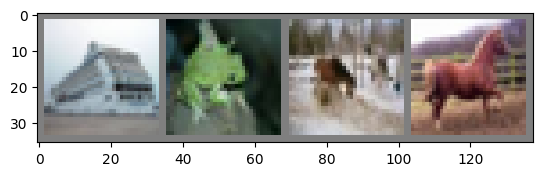

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [7]:
n_classes = 10


class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.skip = nn.Conv2d(3, 32, kernel_size=1)
        self.avgpool = nn.AvgPool2d(kernel_size=8)
        self.fc = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [8]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (skip): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [9]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [12]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = F.cross_entropy(outputs, target)
            loss_log.append(loss.item())

            preds = outputs.argmax(dim=1)
            acc = (preds == target).float().mean()
            acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        preds = outputs.argmax(dim=1)
        acc = (preds == target).float().mean()
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.4935143897258822, train acc: 0.4683949791535163
 val loss: 1.3012737882898209, val acc: 0.538984929120287

Epoch 1
 train loss: 1.189927537436895, train acc: 0.5856130844496286
 val loss: 1.1327335071056448, val acc: 0.6027482269926274

Epoch 2
 train loss: 1.0711584626211763, train acc: 0.6268199921961894
 val loss: 1.0670857832786884, val acc: 0.6256648936170213

Epoch 3
 train loss: 1.013031041927268, train acc: 0.6493536171791104
 val loss: 1.0087395518384081, val acc: 0.6551861702127659

Epoch 4
 train loss: 0.9805139427429144, train acc: 0.6584535780510911
 val loss: 0.9580486064261579, val acc: 0.6681515957446809

Epoch 5
 train loss: 0.94273848551065, train acc: 0.6699774745831324
 val loss: 1.021299040824809, val acc: 0.6518838654173181

Epoch 6
 train loss: 0.922312077700111, train acc: 0.6817584552102377
 val loss: 0.9652991941634644, val acc: 0.6639849292471054

Epoch 7
 train loss: 0.8979412543926204, train acc: 0.6887731784222548
 val loss: 0.925337

Посчитайте точность на тестовой выборке:

In [15]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, \nTest accuracy: {test_acc:.3f}")

Test loss: 0.919, 
Test accuracy: 0.685


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

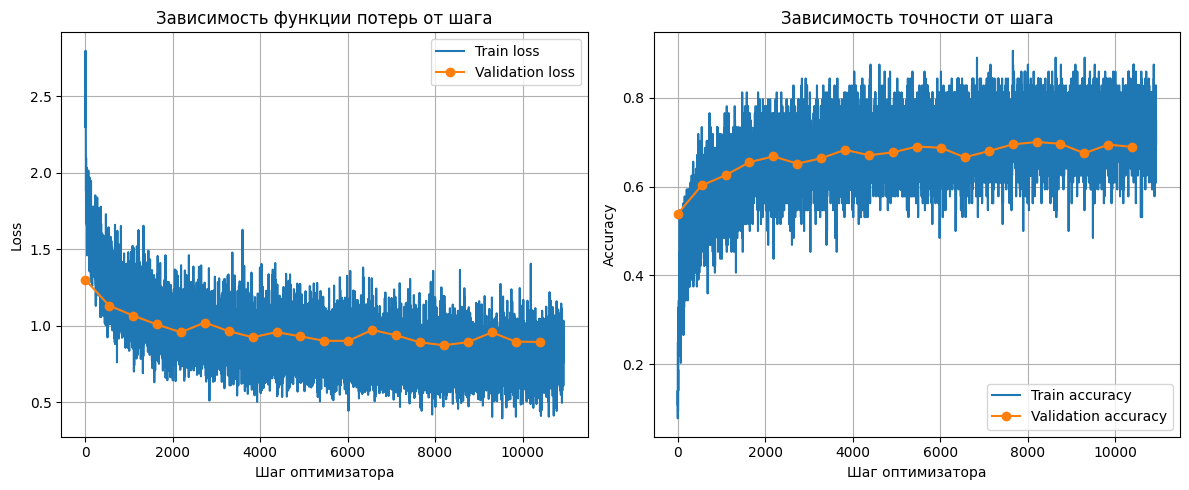

In [16]:
# График функции потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_log, label='Train loss')
plt.plot(
    np.linspace(0, len(train_loss_log), len(val_loss_log), endpoint=False),
    val_loss_log, label='Validation loss', marker='o'
)
plt.xlabel('Шаг оптимизатора')
plt.ylabel('Loss')
plt.title('Зависимость функции потерь от шага')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_acc_log, label='Train accuracy')
plt.plot(
    np.linspace(0, len(train_acc_log), len(val_acc_log), endpoint=False),
    val_acc_log, label='Validation accuracy', marker='o'
)
plt.xlabel('Шаг оптимизатора')
plt.ylabel('Accuracy')
plt.title('Зависимость точности от шага')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.493124875115738, train acc: 0.4656364259597806
 val loss: 1.3105818504982807, val acc: 0.5319813829787234

Epoch 1
 train loss: 1.195531546197818, train acc: 0.5787452664192242
 val loss: 1.229536485925634, val acc: 0.5819370569066799

Epoch 2
 train loss: 1.0664812518212217, train acc: 0.6299621311358603
 val loss: 1.1187054707648907, val acc: 0.6163563829787234

Epoch 3
 train loss: 1.0036620749416036, train acc: 0.6523039631913305
 val loss: 1.0201387352131783, val acc: 0.6472960994598713

Epoch 4
 train loss: 0.967079993357824, train acc: 0.6613794398482147
 val loss: 1.023754031861082, val acc: 0.6446143617021277

Epoch 5
 train loss: 0.9304312315022052, train acc: 0.6774084291248914
 val loss: 1.0991284588549999, val acc: 0.6303413122258288

Epoch 6
 train loss: 0.9112873548127616, train acc: 0.6812075607519481
 val loss: 1.063495746571967, val acc: 0.6498226952045522

Epoch 7
 train loss: 0.8881402516931677, train acc: 0.6907768020682187
 val loss: 0.98049

Посчитайте точность на тестовой выборке:

In [18]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, \nTest accuracy: {test_acc:.3f}")

Test loss: 0.831, 
Test accuracy: 0.712


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [19]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

test_loss, test_acc = test(net, test_loader)
print(f"Test loss (small lr): {test_loss:.3f}, \nTest accuracy: {test_acc:.3f}")

Epoch 0
 train loss: 1.8221214789577114, train acc: 0.3655735832354704
 val loss: 1.6139664690545266, val acc: 0.4387854610351806

Epoch 1
 train loss: 1.5366711178471009, train acc: 0.463587914622462
 val loss: 1.4461223744331522, val acc: 0.4930851063829787

Epoch 2
 train loss: 1.4126955673943054, train acc: 0.5070106425276623
 val loss: 1.363420356080887, val acc: 0.5206781914893617

Epoch 3
 train loss: 1.3430387533560968, train acc: 0.5291647623400365
 val loss: 1.3190424594473331, val acc: 0.5418218085106383

Epoch 4
 train loss: 1.2932352035747368, train acc: 0.5486541852436728
 val loss: 1.266220153899903, val acc: 0.5532358156873824

Epoch 5
 train loss: 1.2490683082470728, train acc: 0.5636262732406421
 val loss: 1.218862546504812, val acc: 0.571343085106383

Epoch 6
 train loss: 1.2092981715524873, train acc: 0.5771701162650337
 val loss: 1.198789790336122, val acc: 0.5776374114320634

Epoch 7
 train loss: 1.183236449030679, train acc: 0.5850458671449525
 val loss: 1.163337

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [20]:
results = []

# CosineAnnealingLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.001)
train_loss, train_acc, val_loss, val_acc = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
results.append(("CosineAnnealingLR", test_loss, test_acc))

# StepLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.2)
train_loss, train_acc, val_loss, val_acc = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
results.append(("StepLR", test_loss, test_acc))

# ExponentialLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
train_loss, train_acc, val_loss, val_acc = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
results.append(("ExponentialLR", test_loss, test_acc))

# Results
for name, loss, acc in results:
    print(f"{name}: Test loss: {loss:.3f}, test accuracy: {acc:.3f}")

Epoch 0
 train loss: 1.452659898200898, train acc: 0.483587424977388
 val loss: 1.2030610467525238, val acc: 0.5776374114320634

Epoch 1
 train loss: 1.1353623205608598, train acc: 0.6038823779365916
 val loss: 1.117222429843659, val acc: 0.6146054965384463

Epoch 2
 train loss: 1.0234235147017665, train acc: 0.6443670018281535
 val loss: 1.0622416410040347, val acc: 0.6348625888215734

Epoch 3
 train loss: 0.9732869192276837, train acc: 0.6618446396081495
 val loss: 0.9844977282463236, val acc: 0.6607269505237011

Epoch 4
 train loss: 0.9327892026909962, train acc: 0.6747110865233803
 val loss: 1.0142810293968687, val acc: 0.6554299646235527

Epoch 5
 train loss: 0.8990858193943226, train acc: 0.6879815226063214
 val loss: 0.9351517618970668, val acc: 0.6758200356300841

Epoch 6
 train loss: 0.8753096855754608, train acc: 0.6931844150998256
 val loss: 0.9380140383192833, val acc: 0.6734485816448292

Epoch 7
 train loss: 0.8510098842532805, train acc: 0.7049694764112859
 val loss: 0.93

Your answers here:

CosineAnnealingLR — постепенно снижает learning rate по косинусной траектории от начального значения до минимального (eta_min) в течение заданного числа эпох (T_max).

StepLR — понижает learning rate в фиксированные моменты: каждые step_size эпох, умножая его на коэффициент gamma.

ExponentialLR — экспоненциально уменьшает learning rate после каждой эпохи по формуле: lr = lr * gamma.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

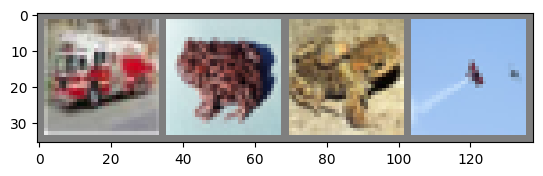

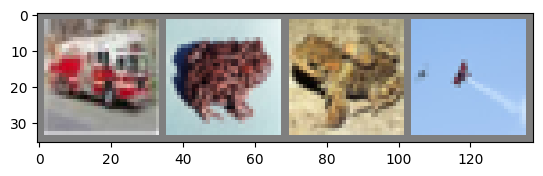

In [22]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [23]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4860792194903443, train acc: 0.4681868634886454
 val loss: 1.2816093498087944, val acc: 0.5434840425531915

Epoch 1
 train loss: 1.1890198784510875, train acc: 0.5830585662364088
 val loss: 1.1331927165072015, val acc: 0.6050310284533399

Epoch 2
 train loss: 1.0615156018319907, train acc: 0.6292398472808615
 val loss: 1.0798493651633567, val acc: 0.6261303191489361

Epoch 3
 train loss: 0.9985967635890466, train acc: 0.6532262014514567
 val loss: 0.9902774534326919, val acc: 0.6584219859001484

Epoch 4
 train loss: 0.9603707406812874, train acc: 0.6661334552102377
 val loss: 0.9925277679524523, val acc: 0.6533244680851064

Epoch 5
 train loss: 0.9236661657772727, train acc: 0.6777512079183101
 val loss: 0.9394863083007488, val acc: 0.6699911348363187

Epoch 6
 train loss: 0.9053980948393262, train acc: 0.6884467224752228
 val loss: 0.9736443689528932, val acc: 0.6606161348363186

Epoch 7
 train loss: 0.893929720251826, train acc: 0.6876632280279993
 val loss: 0.

Посчитайте точность на тестовой выборке:

In [24]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, \nTest accuracy: {test_acc:.3f}")

Test loss: 0.794, 
Test accuracy: 0.730


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [25]:
# ColorJitter
transform_colorjitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_colorjitter
)

results = []

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.001)
train_loss, train_acc, val_loss, val_acc = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
results.append(("ColorJitter", test_loss, test_acc))

Epoch 0
 train loss: 1.5365082198784599, train acc: 0.4534555367403536
 val loss: 1.3343473079356742, val acc: 0.5279920212765957

Epoch 1
 train loss: 1.2185892598938461, train acc: 0.5748481980407478
 val loss: 1.1370270556591926, val acc: 0.6050531914893617

Epoch 2
 train loss: 1.1036583639585993, train acc: 0.614977801085826
 val loss: 1.0550997802551756, val acc: 0.6387189718002969

Epoch 3
 train loss: 1.0437630583860757, train acc: 0.6385152782339064
 val loss: 1.1194315958530345, val acc: 0.6166223404255319

Epoch 4
 train loss: 1.002070292912192, train acc: 0.6541198747031649
 val loss: 1.0676256626210314, val acc: 0.6308289007937654

Epoch 5
 train loss: 0.968495496993091, train acc: 0.665264266173626
 val loss: 0.9734943930138933, val acc: 0.661923758907521

Epoch 6
 train loss: 0.9360313370851102, train acc: 0.6764331418591836
 val loss: 0.9927679325671906, val acc: 0.6558067376309252

Epoch 7
 train loss: 0.9143557024939186, train acc: 0.6856392008512939
 val loss: 1.0056

In [26]:
# RandomRotation
transform_rotation = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_rotation
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.001)
train_loss, train_acc, val_loss, val_acc = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
results.append(("RandomRotation", test_loss, test_acc))

Epoch 0
 train loss: 1.5682512059726053, train acc: 0.43564736232897044
 val loss: 1.383960269359832, val acc: 0.4988031914893617

Epoch 1
 train loss: 1.3108624373537094, train acc: 0.5330414272967379
 val loss: 1.2404203399698785, val acc: 0.5614804965384463

Epoch 2
 train loss: 1.1996583156219567, train acc: 0.5767416427732603
 val loss: 1.1675725498098009, val acc: 0.5918882978723404

Epoch 3
 train loss: 1.1326692067291009, train acc: 0.5999077762284706
 val loss: 1.10103125064931, val acc: 0.6143617021276596

Epoch 4
 train loss: 1.0861501956334716, train acc: 0.6192992622717207
 val loss: 1.100201814732653, val acc: 0.6148936170212767

Epoch 5
 train loss: 1.0515624002521173, train acc: 0.6296764821413449
 val loss: 1.1021726717340186, val acc: 0.6131427305809996

Epoch 6
 train loss: 1.0181230325149662, train acc: 0.6415390767824497
 val loss: 1.0091880022211277, val acc: 0.646099290949233

Epoch 7
 train loss: 1.0058186932499273, train acc: 0.6444486158421532
 val loss: 1.011

Your answers here:

ColorJitter — случайно изменяет яркость, контраст, насыщенность и оттенок изображения.
Это помогает модели стать устойчивее к изменениям освещения и цветового баланса.

RandomRotation — поворачивает изображение на случайный угол из заданного диапазона.
Полезно для классов с ориентационной инвариантностью (например, CIFAR-10).

Обе аугментации помогают повысить обобщающую способность модели.

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [ ]:
# <your code here>